In [10]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [11]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting
tensor([30], dtype=torch.uint8)


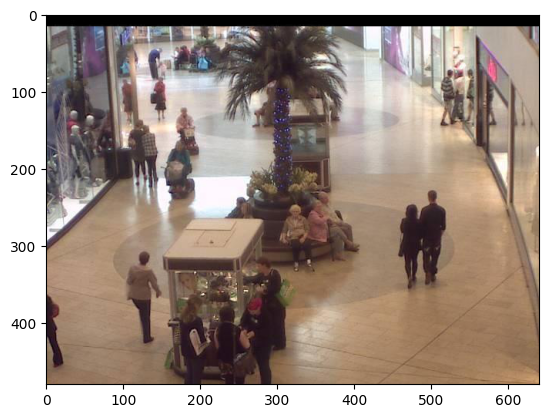

In [12]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=8)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [13]:
# Add this cell before defining Net
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Original image shape: {images.shape}")
print(f"After permute: {images.permute(0, 3, 2, 1).shape}")
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 =  nn.Conv2d(32, 64, 5)
        self.dropout0 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm2d(64)

        self.adaptive_pool = nn.AdaptiveMaxPool2d((12, 12))

        self.fc1 = nn.Linear(64*12*12, 84)
        self.dropout1 = nn.Dropout(0.25)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout0(x)
        x = self.adaptive_pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Original image shape: torch.Size([64, 480, 640, 3])
After permute: torch.Size([64, 3, 640, 480])


In [14]:
def plot_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Accuracy")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Error (average number of people missed)")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Error (average number of people missed)")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

In [15]:
def train(network, device):
    test_acc = np.zeros(50)
    train_acc = np.zeros(50)
    for epoch in range(50):  # loop over the dataset multiple times
        correct = 0
        total = 0
        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            # print(inputs.permute(0, 3, 2, 1).shape)
            # print(labels[0])

            # print(inputs.shape[0]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs.permute(0, 3, 2, 1).float())
            loss = criterion(outputs.float(), labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_acc += torch.mean(torch.abs(outputs.float() - labels)).item() * labels.size(0)
            running_loss += loss.item()

            # print statistics
        train_acc[epoch] = running_acc/total
        print(running_loss)
        total = 0
        running_acc = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data

                images = images.to(device)
                labels = labels.to(device).float()

                outputs = net(images.permute(0, 3, 2, 1).float())
                #_, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)


                error = torch.mean(torch.abs(outputs.float() - labels)).item()
                running_acc += error * labels.size(0)
        test_acc[epoch] = running_acc/total
    plot_graphs("Simple CNN - Linear Regression Model", train_acc, test_acc, "CNN_Plots")

In [16]:
net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0008)

cuda
22456.162658691406
21336.363037109375
20359.362060546875
19343.971435546875
18343.82586669922
17253.630004882812
16079.057434082031
14892.814636230469
13630.093017578125
12321.337341308594
11063.133728027344
9801.992645263672
8567.631225585938
7395.94775390625
6298.162139892578
5234.06005859375
4310.336517333984
3551.553825378418
2792.022933959961
2157.054039001465
1727.5230026245117
1293.9748153686523
989.5516014099121
791.5025901794434
651.6826877593994
537.2164697647095
455.5419511795044
398.1730194091797
332.1065921783447
342.4455614089966
282.5816740989685
282.7287368774414
293.64365005493164
284.5367946624756
290.43785858154297
281.3161954879761
273.75350284576416
243.64942169189453
267.6739978790283
287.96181440353394
252.69814109802246
260.36070489883423
252.40926456451416
286.07636547088623
286.7269678115845
279.4798822402954
282.9894390106201
259.2608094215393
249.57348537445068
272.3053503036499


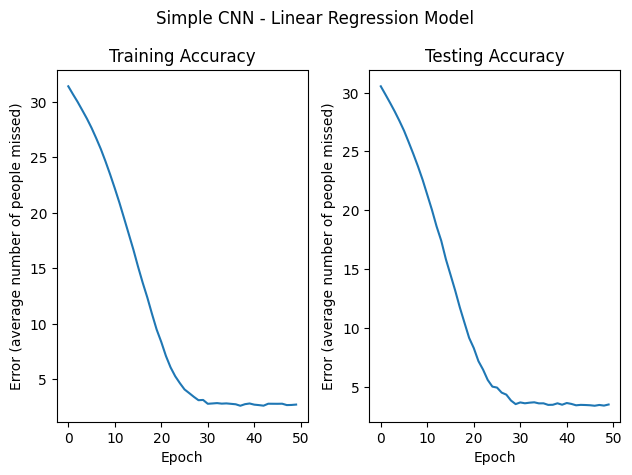

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = net.to(device)
train(net, device)

Predicted:  tensor([18.8121], device='cuda:0', grad_fn=<SelectBackward0>) tensor([34.9503], device='cuda:0', grad_fn=<SelectBackward0>) tensor([40.5132], device='cuda:0', grad_fn=<SelectBackward0>) tensor([26.5099], device='cuda:0', grad_fn=<SelectBackward0>)
Truth:  tensor([25], dtype=torch.uint8) tensor([35], dtype=torch.uint8) tensor([39], dtype=torch.uint8) tensor([32], dtype=torch.uint8)
Average error on the test images (in number of people missed): 3.553566 


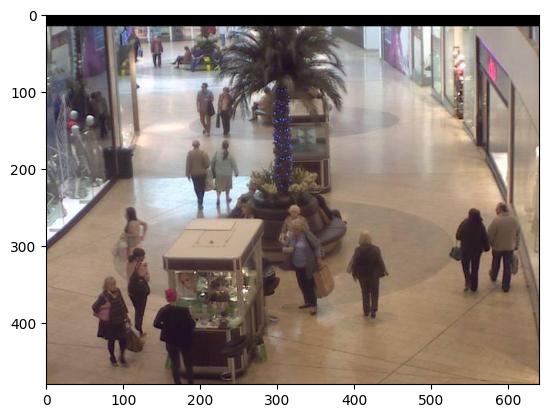

In [18]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = net(images.to(device).permute(0, 3, 2, 1).float())

# _, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % outputs[j]
                              for j in range(4)))
# print images
imshow(images[0])


print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))

total = 0.0
total_error = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images.permute(0, 3, 2, 1).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)


        error = torch.mean(torch.abs(outputs - labels))
        batch_size = labels.size(0)
        total_error += error * batch_size

#print('Accuracy of the network on the 10000 test images: %d %%' % (
    #100 * correct / total))

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))
